In [1]:

import numpy as np
np.random.seed(1234)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.5)

import warnings
warnings.filterwarnings('ignore')
# import os
# import sys
# import gc

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import yfinance as yf

# Get stock data

In [2]:
stock = yf.download('SPY', end='2022-01-01')
stock.describe()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
count,7285.000000,7285.000000,7285.000000,7285.000000,7285.000000,7.285000e+03
mean,153.424481,154.316479,152.433251,153.427416,127.465648,8.421078e+07
std,87.154043,87.517362,86.754048,87.173320,93.033641,9.516960e+07
min,43.343750,43.531250,42.812500,43.406250,25.317486,5.200000e+03
25%,101.639999,102.400002,100.400002,101.625000,71.026283,8.342700e+06
50%,128.759995,129.429993,127.809998,128.669998,93.733612,5.911460e+07
75%,195.350006,196.449997,194.479996,195.580002,171.573792,1.189446e+08
max,477.929993,479.000000,476.059998,477.480011,477.480011,8.710263e+08


In [3]:
daily_return = stock.pct_change(1).dropna()    # 1 for ONE DAY lookback
weekly_return = stock.pct_change(5).dropna()   # 5 for ONE WEEk lookback
monthly_return = stock.pct_change(21).dropna() # 21 for ONE MONTH lookback

changes = [daily_return, weekly_return, monthly_return]

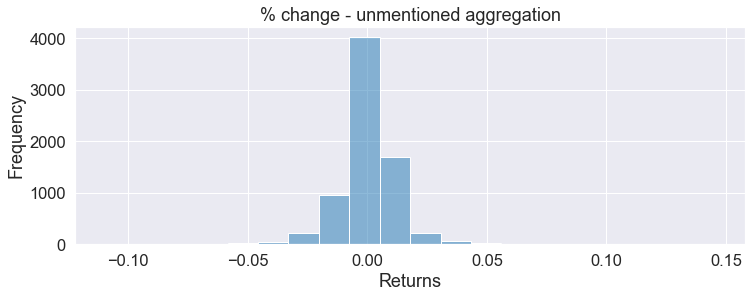

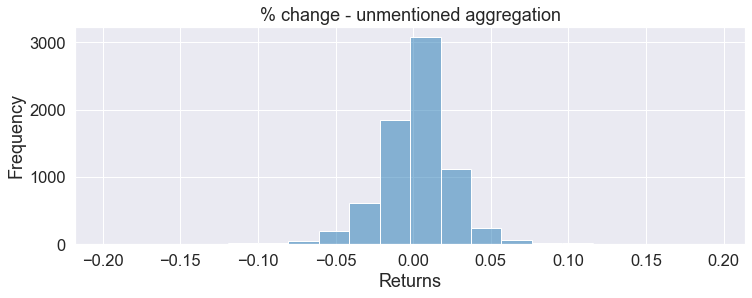

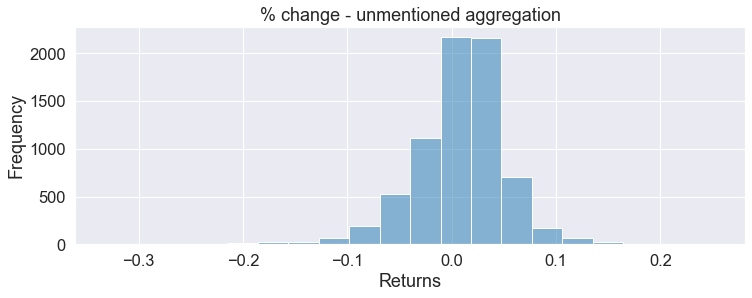

In [4]:
bins = 20

for change in changes:
    _=plt.figure(figsize=(12, 4))
    _=sns.histplot(change.Close, bins=bins, alpha=0.5)
    _=plt.title(f'% change - unmentioned aggregation') 
    _=plt.xlabel('Returns')
    _=plt.ylabel('Frequency')
    _=plt.show()


In [5]:
values, bins = pd.qcut(daily_return.Close, 10, retbins=True)
bins

array([-0.10942374, -0.01189284, -0.00639293, -0.00306977, -0.00099644,
        0.00064551,  0.00249915,  0.00458733,  0.00744463,  0.01219228,
        0.14519772])

In [6]:
# values, bins = pd.cut(daily_return.Close, bins=20, retbins=True,)
# manully set the bins inspired by `bins`
# bins = [-0.45, # negative skew
#             -0.020,
#                 -0.007,
#                     -0.002,
#                     0.002,
#                 0.006,
#             0.015,
#          ]

# data = daily_return.Close
# mean, std = data.mean(), data.std()
# bins = [[mean-std*i, mean+std*i] for i in [0.05, 0.1]]
# bins = np.array(bins).flatten()
# bins.shape
# bins

In [7]:
Close = np.zeros_like(daily_return.Close)

for idx_bin, bin in enumerate(bins):
    for idx_close, close in enumerate(daily_return.Close):
        if close >= bin: 
            # Close[idx_close] = bin # for setting the bins
            Close[idx_close] = idx_bin


Close = Close.astype(int)
for i in range(len(Close)): 
    if Close[i] == 10: 
        Close[i] = 9
print(f'len for Close: {len(set(Close))} | set of Close {list(set(Close))}')
pd.DataFrame(Close).value_counts().sort_index()



len for Close: 10 | set of Close [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


0    729
1    728
2    728
3    729
4    728
5    728
6    729
7    728
8    728
9    729
dtype: int64

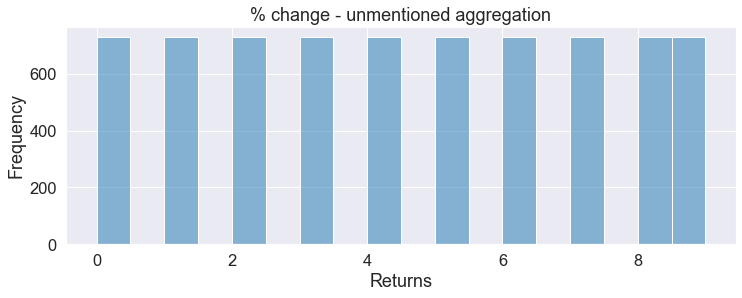

In [8]:
_=plt.figure(figsize=(12, 4))
_=sns.histplot(Close, alpha=0.5)
_=plt.title(f'% change - unmentioned aggregation') 
_=plt.xlabel('Returns')
_=plt.ylabel('Frequency')
_=plt.show()

# Make model

In [9]:
import torch
import pyro # need graphwiz exe and ion the PATH
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [10]:
# example from https://pyro.ai/examples/intro_long.html
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]] #  isInAfrica, Terrain Ruggedness Index, Real GDP per capita for the year 2000
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [11]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

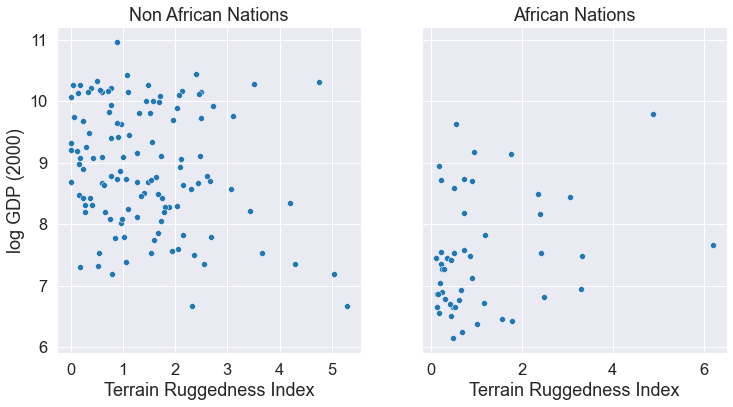

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")

sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [13]:
# # Formula for the model
# # mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

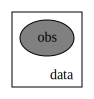

In [14]:
def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp))

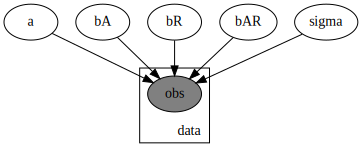

In [15]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + (b_a * is_cont_africa) + (b_r * ruggedness) + (b_ar * is_cont_africa * ruggedness)

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp))

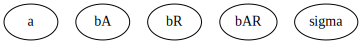

In [16]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp))


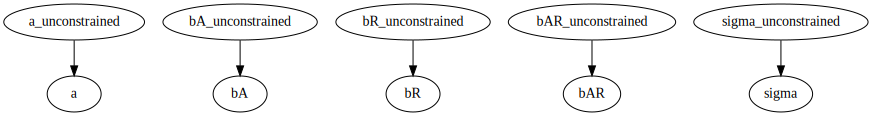

NameError: name 'smoke_test' is not defined

In [17]:
mvn_guide = pyro.infer.autoguide.AutoNormal(model)
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp))

# pyro.clear_param_store()

svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

_=plt.figure(figsize=(5, 2))
_=plt.plot(losses)
_=plt.xlabel("SVI step")
_=plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

## Stochastic Variational Inference 


Elbo loss: 692.775346159935
Elbo loss: 535.5204437971115
Elbo loss: 475.83283162117004
Elbo loss: 411.07119220495224
Elbo loss: 321.038734793663
Elbo loss: 254.1334416270256
Elbo loss: 247.9575873017311
Elbo loss: 246.10228425264359
Elbo loss: 248.71679812669754
Elbo loss: 251.47358214855194
Wall time: 6.58 s


Text(0, 0.5, 'ELBO loss')

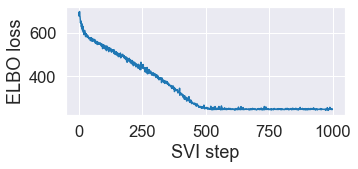

In [ ]:
%%time
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]

AutoNormal.locs.a 9.189552
AutoNormal.scales.a 0.06889028
AutoNormal.locs.bA -1.8661656
AutoNormal.scales.bA 0.12994632
AutoNormal.locs.bR -0.15724075
AutoNormal.scales.bR 0.041591078
AutoNormal.locs.bAR 0.33631882
AutoNormal.scales.bAR 0.0809452
AutoNormal.locs.sigma -2.232725
AutoNormal.scales.sigma 0.054550704


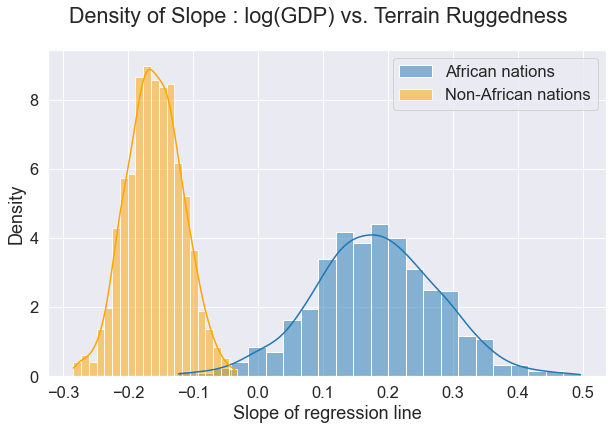

In [ ]:
fig = plt.figure(figsize=(10, 6))
_=sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
_=sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
_=fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
_=plt.xlabel("Slope of regression line")
_=plt.legend()
_=plt.show()

In [ ]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

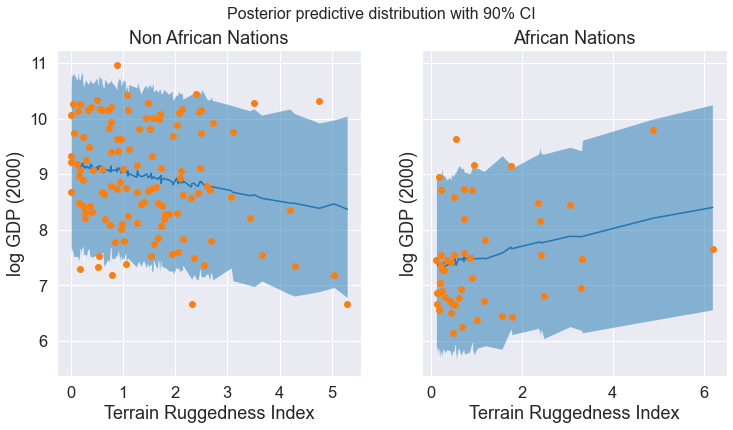

In [ ]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

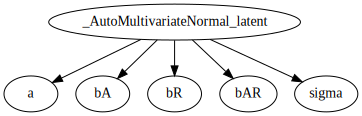

Elbo loss: 1245.5511488318443
Elbo loss: 726.7470285892487
Elbo loss: 658.7611298561096
Elbo loss: 621.3140408992767
Elbo loss: 592.1702728271484
Elbo loss: 579.5223612785339
Elbo loss: 551.466352045536
Elbo loss: 556.6286613941193
Elbo loss: 528.4461822509766
Elbo loss: 470.75562477111816


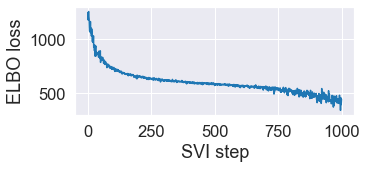

In [ ]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp))

pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

_=plt.figure(figsize=(5, 2))
_=plt.plot(losses)
_=plt.xlabel("SVI step")
_=plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]